In [111]:
# %%
import pandas as pd, json, re, os, natsort
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# print Source Function / Function / Call Stack column without truncation
pd.set_option('display.max_colwidth', None)
# display all columns
pd.set_option('display.max_columns', None)


plt.rc('axes', labelsize=63)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=60)    # fontsize of the tick labels
plt.rc('ytick', labelsize=60)    # fontsize of the tick labels
plt.rc('legend', fontsize=50)    # legend fontsize
# # increase size of axis label size
plt.rcParams['axes.labelsize'] = 65
# increase title size
plt.rcParams['axes.titlesize'] = 65
# increase space between axis label and axis
plt.rcParams['axes.labelpad'] = 50
# increase space between title and plot
plt.rcParams['axes.titlepad'] = 50
plt.rcParams['font.size'] = 50

# %%
mapping_file = '/mydata/rbachkaniwala3/code/rajveerb-ml-pipeline-benchmark/code/image_classification/analysis/hw_event_analysis/mapping_funcs.json'
uarch_dir ='/mydata/rbachkaniwala3/code/rajveerb-ml-pipeline-benchmark/code/image_classification/analysis/hw_event_analysis/vtune_uarch_csvs'

In [112]:
# load a json file
with open(mapping_file) as f:
    data = json.load(f)

cpp_funcs = set()

for py_func in data['op_to_func']:
    # if py_func == 'RandomResizedCrop' or py_func == 'convertRGB':
    for cpp_func in data['op_to_func'][py_func]:
        cpp_funcs.add(cpp_func.split('|')[0])
interested_functions = list(cpp_funcs)

# previous interested_functions =

# ["__memmove_avx_unaligned_erms",\
# "_int_free",\
# "ImagingResampleHorizontal_8bpc",\
# "ImagingResampleVertical_8bpc",\
# "ImagingFlipLeftRight",\
# "ImagingPackRGB",\
# "munmap",\
# "copy_kernel",\
# "div_true_kernel",\
# "direct_copy_kernel",\
# "add_kernel",\
# "decompress_onepass",\
# "jpeg_idct_islow",\
# "jpeg_idct_16x16",\
# "ycc_rgb_convert",\
# "decode_mcu",\
# "ImagingUnpackRGB",\
# "__memset_avx2_unaligned_erms",\
# "__libc_calloc",\
#         ]
uarch_files = []
# loop through uarch_dir and find csv files
for file in os.listdir(uarch_dir):
    if not file.endswith(".csv"):
        print("Files other than csv exist ", uarch_dir)
        exit(1)
    uarch_files.append(file)

# natsort uarch_files
uarch_files = natsort.natsorted(uarch_files)
print(uarch_files)

['b128_gpu1.csv', 'b128_gpu2.csv', 'b128_gpu3.csv', 'b128_gpu4.csv', 'b256_gpu1.csv', 'b256_gpu2.csv', 'b256_gpu3.csv', 'b256_gpu4.csv', 'b512_gpu1.csv', 'b512_gpu2.csv', 'b512_gpu3.csv', 'b512_gpu4.csv', 'b1024_gpu2.csv', 'b1024_gpu3.csv', 'b1024_gpu4.csv']


In [113]:
def display_comparison(config1,config2):
    combined_df = pd.DataFrame()
    # loop through uarch_dir and find csv files
    for uarch_file_ in uarch_files:
        if not file.endswith(".csv"):
            print("Files other than csv exist ", uarch_dir)
            exit(1)
        
        if not(config1 in uarch_file_ or config2 in uarch_file_):
            continue


        uarch_file = os.path.join(uarch_dir, uarch_file_)

        # %%
        #  read csv separated by tab
        df = pd.read_csv(uarch_file, sep='\t')

        # %%
        # remove trailing "s" in 'CPU Time' column and cast the column to float
        df['CPU Time'] = df['CPU Time'].str.rstrip('s').astype(float)
        # create a new column called "CPU Time %" from "CPU Time" column
        df['CPU Time %'] = df['CPU Time'] / df['CPU Time'].sum() * 100

        # %%
        # sort by column 'CPU Time' and reset index
        df = df.sort_values(by=['CPU Time'], ascending=False).reset_index(drop=True)

        # %%
        #  find index of interested functions in the dataframe in "Source Function / Function / Call Stack" column
        indices = {}
        empty_indices = []
        print('uarch_file: ', uarch_file)
        for func in interested_functions:
            # escape special characters
            func_ = re.escape(func)
            indices_for_func = df[df["Source Function / Function / Call Stack"].str.contains(func_)].index.values
            # if empty, add to empty_indices
            if len(indices_for_func) == 0:
                empty_indices.append(func)
            else:
                indices[func] = indices_for_func
        # print("C/C++ functions not found in dataframe:")
        # print(empty_indices)
        # print("C/C++ functions (indices) found in dataframe:")    
        # for func in indices:
        #     print("Index:",indices[func],"Function: ", func)
        # print('\n\n')

        # %%
        # find above functions in the dataframe and map the function name to the one in interested_functions

        # for function in interested_functions:
        #     df.loc[df['Source Function / Function / Call Stack'].str.contains(function), 'Source Function / Function / Call Stack'] = function


        # %%
        # combine all the interested functions' row into a dataframe
        df2 = pd.DataFrame()
        for func in indices:
            df2 = pd.concat([df2,df.iloc[indices[func]]])

        # %%
        # sort by 'CPU Time' column and reset index
        df2 = df2.sort_values(by=['CPU Time %'], ascending=False).reset_index(drop=True)
        # rename 'CPU Time' column to 'CPU Time (s)'
        df2 = df2.rename(columns={"CPU Time": "CPU Time (s)"})
        remove_cols = [
            "Source File",
            "Start Address",
            "Module",
            "Average CPU Frequency",
            "Clockticks",
            "Instructions Retired",
            "CPI Rate",
            "Function (Full)"
        ] 
        # remove columns
        df2 = df2.drop(columns=remove_cols)

        # add column 'uarch_file' to df2 with value uarch_file
        tmp = uarch_file_.split('.csv')[0]
        batch_size,gpus = tmp.split('_')
        batch_size = batch_size.split('b')[1]
        gpus = gpus.split('gpu')[1]
        df2['batch_size'] = int(batch_size)
        df2['gpus'] = int(gpus)

        percentage_symbol_cols = [
            'Retiring',
            'Front-End Bound', 
            'Bad Speculation', 
            'L1 Bound', 
            'L2 Bound',
            'L3 Bound', 
            'Memory Bandwidth', 
            'Local DRAM', 
            'Remote DRAM',
            'Remote Cache', 
            'Store Bound', 
            'Core Bound',
            ]
        
        # remove the % symbol and cast the column to float
        for col in percentage_symbol_cols:
            df2[col] = df2[col].str.rstrip('%').astype(float)


        # %%
        # print sum of 'CPU Time %' contributed
        # print config i.e. batch_size and gpus
        print(f"sum of 'CPU Time %' contributed by config {(batch_size,gpus)}: {df2['CPU Time %'].sum():.2f}%")
        
        # rename 'Source Function / Function / Call Stack' column to 'Functions'
        df2 = df2.rename(columns={"Source Function / Function / Call Stack": "Functions"})
        # %%
        # set index to 'Source Function / Function / Call Stack' column
        df2 = df2.set_index('Functions')

        def flatten(S):
            if len(S)==1:
                return [S[0]]
            if isinstance(S[0], list):
                return flatten(S[0]) + flatten(S[1:])
            return S[:1] + flatten(S[1:])

        combined_df = pd.concat([combined_df, df2])
    # %%
    # reset index
    combined_df = combined_df.reset_index()


    func_rename = {
        'c10::function_ref<void (char**, long const*, long, long)>::callback_fn<at::native::AVX2::VectorizedLoop2d<at::native::AVX2::direct_copy_kernel(at::TensorIteratorBase&)::{lambda()#3}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda(float)#1}, at::native::AVX2::direct_copy_kernel(at::TensorIteratorBase&)::{lambda()#3}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda(at::vec::AVX2::Vectorized<float>)#2}>>': 'AVX2::direct_copy_kernel(float)',
        'at::native::AVX2::vectorized_loop<at::native::(anonymous namespace)::div_true_kernel(at::TensorIteratorBase&)::{lambda()#1}::operator()(void) const::{lambda()#2}::operator()(void) const::{lambda(floatfloat)#1}&, at::native::(anonymous namespace)::div_true_kernel(at::TensorIteratorBase&)::{lambda()#1}::operator()(void) const::{lambda()#2}::operator()(void) const::{lambda(at::vec::AVX2::Vectorized<float>at::vec::AVX2::Vectorized<float>)#2}&>.isra.0' :'AVX2::div_true_kernel(float)',
        'c10::function_ref<void (char**, long const*, long, long)>::callback_fn<at::native::AVX2::VectorizedLoop2d<at::native::AVX2::direct_copy_kernel(at::TensorIteratorBase&)::{lambda()#3}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda(unsigned char)#1}, at::native::AVX2::direct_copy_kernel(at::TensorIteratorBase&)::{lambda()#3}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda(at::vec::AVX2::Vectorized<unsigned char>)#2}>>' : 'AVX2::direct_copy_kernel(unsigned char)',
        'c10::function_ref<void (char**, long const*, long, long)>::callback_fn<at::TensorIteratorBase::loop_2d_from_1d<at::native::AVX2::copy_kernel(at::TensorIterator&, bool)::{lambda()#1}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda(char**long const*, long)#1}>(, signed char, at::native::AVX2::copy_kernel(at::TensorIterator&, bool)::{lambda()#1}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda()#1}::operator()(void) const::{lambda(char**long const*, long)#1} const&)::{lambda(char**long const*, long, long)#1}>' : 'AVX2::copy_kernel(char**long const*, long, long)',
        'c10::function_ref<void (char**, long const*, long, long)>::callback_fn<at::native::AVX2::VectorizedLoop2d<at::native::(anonymous namespace)::add_kernel(at::TensorIteratorBase&, c10::Scalar const&)::{lambda()#1}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda(floatfloat)#1}, at::native::(anonymous namespace)::add_kernel(at::TensorIteratorBase&, c10::Scalar const&)::{lambda()#1}::operator()(void) const::{lambda()#7}::operator()(void) const::{lambda(at::vec::AVX2::Vectorized<float>at::vec::AVX2::Vectorized<float>)#2}>>' : 'add_kernel(float)',
    }

    # replace function names in 'Source Function / Function / Call Stack' column

    combined_df['Functions'] = combined_df['Functions'].replace(func_rename)  

    # Remove functions taking less than 1% of CPU total time
    functions_to_remove = combined_df[combined_df.groupby('Functions')['CPU Time %'].transform('min') < 1]['Functions']
    
    print("Below are functions taking less than 1% of CPU total time in at least one configuration:")
    print(functions_to_remove.unique())

    # print high level functions these functions belong to
    print("Below are high level functions these functions belong to:")
    for func in functions_to_remove.unique():
        for py_func in data['op_to_func']:
            for cpp_func in data['op_to_func'][py_func]:
                if cpp_func.split('|')[0] == func:
                    print('\t' + py_func)
                    break

    # remove functions in functions_to_remove from combined_df
    combined_df = combined_df[~combined_df['Functions'].isin(functions_to_remove)]

    return combined_df


In [114]:
batch_size_config1 = 256
batch_size_config2 = 1024
gpus_config1 = 1
gpus_config2 = 4
config1 = 'b' + str(batch_size_config1) + '_gpu' + str(gpus_config1)
config2  = 'b' + str(batch_size_config2) + '_gpu' + str(gpus_config2)

In [115]:
df = display_comparison(config1,config2)

uarch_file:  /mydata/rbachkaniwala3/code/rajveerb-ml-pipeline-benchmark/code/image_classification/analysis/hw_event_analysis/vtune_uarch_csvs/b256_gpu1.csv
sum of 'CPU Time %' contributed by config ('256', '1'): 71.04%
uarch_file:  /mydata/rbachkaniwala3/code/rajveerb-ml-pipeline-benchmark/code/image_classification/analysis/hw_event_analysis/vtune_uarch_csvs/b1024_gpu4.csv
sum of 'CPU Time %' contributed by config ('1024', '4'): 73.41%
Below are functions taking less than 1% of CPU total time in at least one configuration:
['AVX2::direct_copy_kernel(unsigned char)' 'ImagingPackRGB'
 'AVX2::copy_kernel(char**long const*, long, long)' 'add_kernel(float)'
 '__memset_avx2_unaligned_erms' 'ImagingFlipLeftRight' '_int_free'
 '__libc_calloc']
Below are high level functions these functions belong to:
	ToTensor
	convertRGB
	RandomHorizontalFlip
	RandomResizedCrop
	ToTensor
	convertRGB


In [116]:
df.head(len(df))

,Functions,CPU Time (s),Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound,CPU Time %,batch_size,gpus
0,decode_mcu,1200.671,40.6,8.1,40.8,17.1,0.2,0.1,18.6,0.0,0.0,0.0,0.0,6.5,20.662084,256,1
1,jpeg_idct_islow,948.686,68.5,2.6,6.2,1.8,0.0,0.0,17.2,0.0,0.0,0.0,0.2,21.3,16.325729,256,1
2,ImagingResampleHorizontal_8bpc,413.590,89.8,1.2,0.8,0.9,0.0,0.1,16.4,0.0,0.0,0.0,0.0,7.7,7.117380,256,1
3,ycc_rgb_convert,342.715,86.0,0.4,1.4,0.2,0.0,0.0,17.2,0.0,0.0,0.0,0.0,11.3,5.897707,256,1
4,ImagingResampleVertical_8bpc,288.125,87.0,0.2,0.5,0.9,0.1,0.2,9.7,0.6,0.0,0.0,0.0,11.6,4.958280,256,1
5,AVX2::direct_copy_kernel(float),205.865,4.8,0.6,0.0,8.8,13.1,12.7,77.8,100.0,100.0,1.7,90.1,5.2,3.542686,256,1
6,jpeg_idct_16x16,142.250,88.8,1.1,2.0,0.3,0.0,0.0,15.5,0.0,0.0,0.0,0.3,7.8,2.447949,256,1
7,__memmove_avx_unaligned_erms,138.120,8.2,1.8,0.0,20.6,14.4,31.2,70.3,21.0,5.1,0.0,80.0,10.0,2.376877,256,1
8,AVX2::div_true_kernel(float),99.485,13.7,0.3,0.0,25.9,11.6,6.4,92.1,0.0,0.0,0.0,8.5,41.1,1.712016,256,1
9,decompress_onepass,96.815,54.7,5.1,22.6,2.8,0.1,0.1,15.6,0.0,0.0,0.0,0.2,15.6,1.666068,256,1


In [117]:
# get dataframe for batch_size = 256 and gpus = 1
df1 = df[df['batch_size'] == batch_size_config1]
df1 = df1[df1['gpus'] == gpus_config1].copy().reset_index(drop=True)
# get dataframe for batch_size = 1024 and gpus = 4
df2 = df[df['batch_size'] == batch_size_config2]
df2 = df2[df2['gpus'] == gpus_config2].copy().reset_index(drop=True)

# drop 'batch_size' and 'gpus' columns
df1 = df1.drop(columns=['batch_size', 'gpus'])
df2 = df2.drop(columns=['batch_size', 'gpus'])
# drop CPU Time % column
df1 = df1.drop(columns=['CPU Time %'])
df2 = df2.drop(columns=['CPU Time %'])


In [118]:
df1.head(len(df1))


,Functions,CPU Time (s),Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound
0,decode_mcu,1200.671,40.6,8.1,40.8,17.1,0.2,0.1,18.6,0.0,0.0,0.0,0.0,6.5
1,jpeg_idct_islow,948.686,68.5,2.6,6.2,1.8,0.0,0.0,17.2,0.0,0.0,0.0,0.2,21.3
2,ImagingResampleHorizontal_8bpc,413.590,89.8,1.2,0.8,0.9,0.0,0.1,16.4,0.0,0.0,0.0,0.0,7.7
3,ycc_rgb_convert,342.715,86.0,0.4,1.4,0.2,0.0,0.0,17.2,0.0,0.0,0.0,0.0,11.3
4,ImagingResampleVertical_8bpc,288.125,87.0,0.2,0.5,0.9,0.1,0.2,9.7,0.6,0.0,0.0,0.0,11.6
5,AVX2::direct_copy_kernel(float),205.865,4.8,0.6,0.0,8.8,13.1,12.7,77.8,100.0,100.0,1.7,90.1,5.2
6,jpeg_idct_16x16,142.250,88.8,1.1,2.0,0.3,0.0,0.0,15.5,0.0,0.0,0.0,0.3,7.8
7,__memmove_avx_unaligned_erms,138.120,8.2,1.8,0.0,20.6,14.4,31.2,70.3,21.0,5.1,0.0,80.0,10.0
8,AVX2::div_true_kernel(float),99.485,13.7,0.3,0.0,25.9,11.6,6.4,92.1,0.0,0.0,0.0,8.5,41.1
9,decompress_onepass,96.815,54.7,5.1,22.6,2.8,0.1,0.1,15.6,0.0,0.0,0.0,0.2,15.6


In [119]:
df2.head(len(df2))

,Functions,CPU Time (s),Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound
0,decode_mcu,1840.382,41.6,8.5,42.9,17.0,0.1,0.1,12.3,0.0,0.0,0.0,0.0,4.3
1,jpeg_idct_islow,1474.191,70.1,2.8,5.9,1.8,0.0,0.0,10.6,0.0,0.0,0.0,0.2,19.8
2,ImagingResampleHorizontal_8bpc,658.551,87.9,1.6,0.0,1.3,0.1,0.1,12.6,0.0,0.0,0.0,0.1,9.5
3,ycc_rgb_convert,533.026,84.1,0.6,0.0,0.3,0.0,0.0,11.2,0.2,0.0,0.0,0.1,12.9
4,ImagingResampleVertical_8bpc,462.315,85.1,0.4,1.4,1.3,0.0,0.3,8.0,0.0,0.0,0.0,0.1,12.3
5,__memmove_avx_unaligned_erms,245.130,6.4,2.0,0.9,21.7,12.3,29.5,63.4,32.9,0.9,0.0,81.1,10.2
6,jpeg_idct_16x16,227.015,82.7,1.3,0.0,0.4,0.0,0.0,10.1,0.0,0.0,0.0,0.7,15.9
7,AVX2::direct_copy_kernel(float),220.145,5.2,0.7,0.2,12.7,11.0,15.2,81.8,100.0,100.0,0.0,94.8,4.6
8,AVX2::div_true_kernel(float),161.430,12.7,0.5,0.7,23.0,13.8,6.2,86.7,0.0,0.0,0.0,7.8,41.5
9,decompress_onepass,145.045,54.6,5.2,21.6,2.7,0.0,0.1,10.4,0.0,0.0,0.0,0.3,16.8


In [120]:
# multiply each column in df1 and df2 by CPU Time % and divide by 100 except for column 'Functions' and CPU Time %
df1[df1.columns[1:]] = df1[df1.columns[1:]].mul(df1['CPU Time (s)'].div(100), axis=0)
df2[df2.columns[1:]] = df2[df2.columns[1:]].mul(df2['CPU Time (s)'].div(100), axis=0)


In [121]:
# drop CPU Time (s) column
df1 = df1.drop(columns=['CPU Time (s)'])
df2 = df2.drop(columns=['CPU Time (s)'])

In [122]:
df1.head(len(df1))

,Functions,Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound
0,decode_mcu,487.472426,97.254351,489.873768,205.314741,2.401342,1.200671,223.324806,0.00000,0.00000,0.000000,0.000000,78.043615
1,jpeg_idct_islow,649.849910,24.665836,58.818532,17.076348,0.000000,0.000000,163.173992,0.00000,0.00000,0.000000,1.897372,202.070118
2,ImagingResampleHorizontal_8bpc,371.403820,4.963080,3.308720,3.722310,0.000000,0.413590,67.828760,0.00000,0.00000,0.000000,0.000000,31.846430
3,ycc_rgb_convert,294.734900,1.370860,4.798010,0.685430,0.000000,0.000000,58.946980,0.00000,0.00000,0.000000,0.000000,38.726795
4,ImagingResampleVertical_8bpc,250.668750,0.576250,1.440625,2.593125,0.288125,0.576250,27.948125,1.72875,0.00000,0.000000,0.000000,33.422500
5,AVX2::direct_copy_kernel(float),9.881520,1.235190,0.000000,18.116120,26.968315,26.144855,160.162970,205.86500,205.86500,3.499705,185.484365,10.704980
6,jpeg_idct_16x16,126.318000,1.564750,2.845000,0.426750,0.000000,0.000000,22.048750,0.00000,0.00000,0.000000,0.426750,11.095500
7,__memmove_avx_unaligned_erms,11.325840,2.486160,0.000000,28.452720,19.889280,43.093440,97.098360,29.00520,7.04412,0.000000,110.496000,13.812000
8,AVX2::div_true_kernel(float),13.629445,0.298455,0.000000,25.766615,11.540260,6.367040,91.625685,0.00000,0.00000,0.000000,8.456225,40.888335
9,decompress_onepass,52.957805,4.937565,21.880190,2.710820,0.096815,0.096815,15.103140,0.00000,0.00000,0.000000,0.193630,15.103140


In [123]:
df2.head(len(df2))

,Functions,Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound
0,decode_mcu,765.598912,156.432470,789.523878,312.864940,1.840382,1.840382,226.366986,0.000000,0.00000,0.0,0.000000,79.136426
1,jpeg_idct_islow,1033.407891,41.277348,86.977269,26.535438,0.000000,0.000000,156.264246,0.000000,0.00000,0.0,2.948382,291.889818
2,ImagingResampleHorizontal_8bpc,578.866329,10.536816,0.000000,8.561163,0.658551,0.658551,82.977426,0.000000,0.00000,0.0,0.658551,62.562345
3,ycc_rgb_convert,448.274866,3.198156,0.000000,1.599078,0.000000,0.000000,59.698912,1.066052,0.00000,0.0,0.533026,68.760354
4,ImagingResampleVertical_8bpc,393.430065,1.849260,6.472410,6.010095,0.000000,1.386945,36.985200,0.000000,0.00000,0.0,0.462315,56.864745
5,__memmove_avx_unaligned_erms,15.688320,4.902600,2.206170,53.193210,30.150990,72.313350,155.412420,80.647770,2.20617,0.0,198.800430,25.003260
6,jpeg_idct_16x16,187.741405,2.951195,0.000000,0.908060,0.000000,0.000000,22.928515,0.000000,0.00000,0.0,1.589105,36.095385
7,AVX2::direct_copy_kernel(float),11.447540,1.541015,0.440290,27.958415,24.215950,33.462040,180.078610,220.145000,220.14500,0.0,208.697460,10.126670
8,AVX2::div_true_kernel(float),20.501610,0.807150,1.130010,37.128900,22.277340,10.008660,139.959810,0.000000,0.00000,0.0,12.591540,66.993450
9,decompress_onepass,79.194570,7.542340,31.329720,3.916215,0.000000,0.145045,15.084680,0.000000,0.00000,0.0,0.435135,24.367560


In [124]:
# get functions that are not common in both dataframes
df_unique = df1[~df1['Functions'].isin(df2['Functions'])]

In [125]:
# check if empty
if len(df_unique) == 0:
    print("No unique functions in both dataframes")

No unique functions in both dataframes


In [126]:
# map each function in df1 based on CPU Time % to a integer
func_to_int = {}
for i, func in enumerate(df1['Functions']):
    func_to_int[func] = i

In [127]:
# subtract df1 from df2 across Functions column
df3 = df2.set_index('Functions').sub(df1.set_index('Functions'), fill_value=0).reset_index()

In [128]:
# sort index in df3 based on func_to_int
df3 = df3.set_index(df3['Functions'].map(func_to_int)).sort_index().reset_index(drop=True)

In [129]:
df3.head(len(df3))

,Functions,Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound
0,decode_mcu,278.126486,59.178119,299.650110,107.550199,-0.560960,0.639711,3.042180,0.000000,0.00000,0.000000,0.000000,1.092811
1,jpeg_idct_islow,383.557981,16.611512,28.158737,9.459090,0.000000,0.000000,-6.909746,0.000000,0.00000,0.000000,1.051010,89.819700
2,ImagingResampleHorizontal_8bpc,207.462509,5.573736,-3.308720,4.838853,0.658551,0.244961,15.148666,0.000000,0.00000,0.000000,0.658551,30.715915
3,ycc_rgb_convert,153.539966,1.827296,-4.798010,0.913648,0.000000,0.000000,0.751932,1.066052,0.00000,0.000000,0.533026,30.033559
4,ImagingResampleVertical_8bpc,142.761315,1.273010,5.031785,3.416970,-0.288125,0.810695,9.037075,-1.728750,0.00000,0.000000,0.462315,23.442245
5,AVX2::direct_copy_kernel(float),1.566020,0.305825,0.440290,9.842295,-2.752365,7.317185,19.915640,14.280000,14.28000,-3.499705,23.213095,-0.578310
6,jpeg_idct_16x16,61.423405,1.386445,-2.845000,0.481310,0.000000,0.000000,0.879765,0.000000,0.00000,0.000000,1.162355,24.999885
7,__memmove_avx_unaligned_erms,4.362480,2.416440,2.206170,24.740490,10.261710,29.219910,58.314060,51.642570,-4.83795,0.000000,88.304430,11.191260
8,AVX2::div_true_kernel(float),6.872165,0.508695,1.130010,11.362285,10.737080,3.641620,48.334125,0.000000,0.00000,0.000000,4.135315,26.105115
9,decompress_onepass,26.236765,2.604775,9.449530,1.205395,-0.096815,0.048230,-0.018460,0.000000,0.00000,0.000000,0.241505,9.264420


In [137]:
# save df3 to csv
df3.to_csv(f'./{config2}_minus_{config1}_diff.csv', index=False)

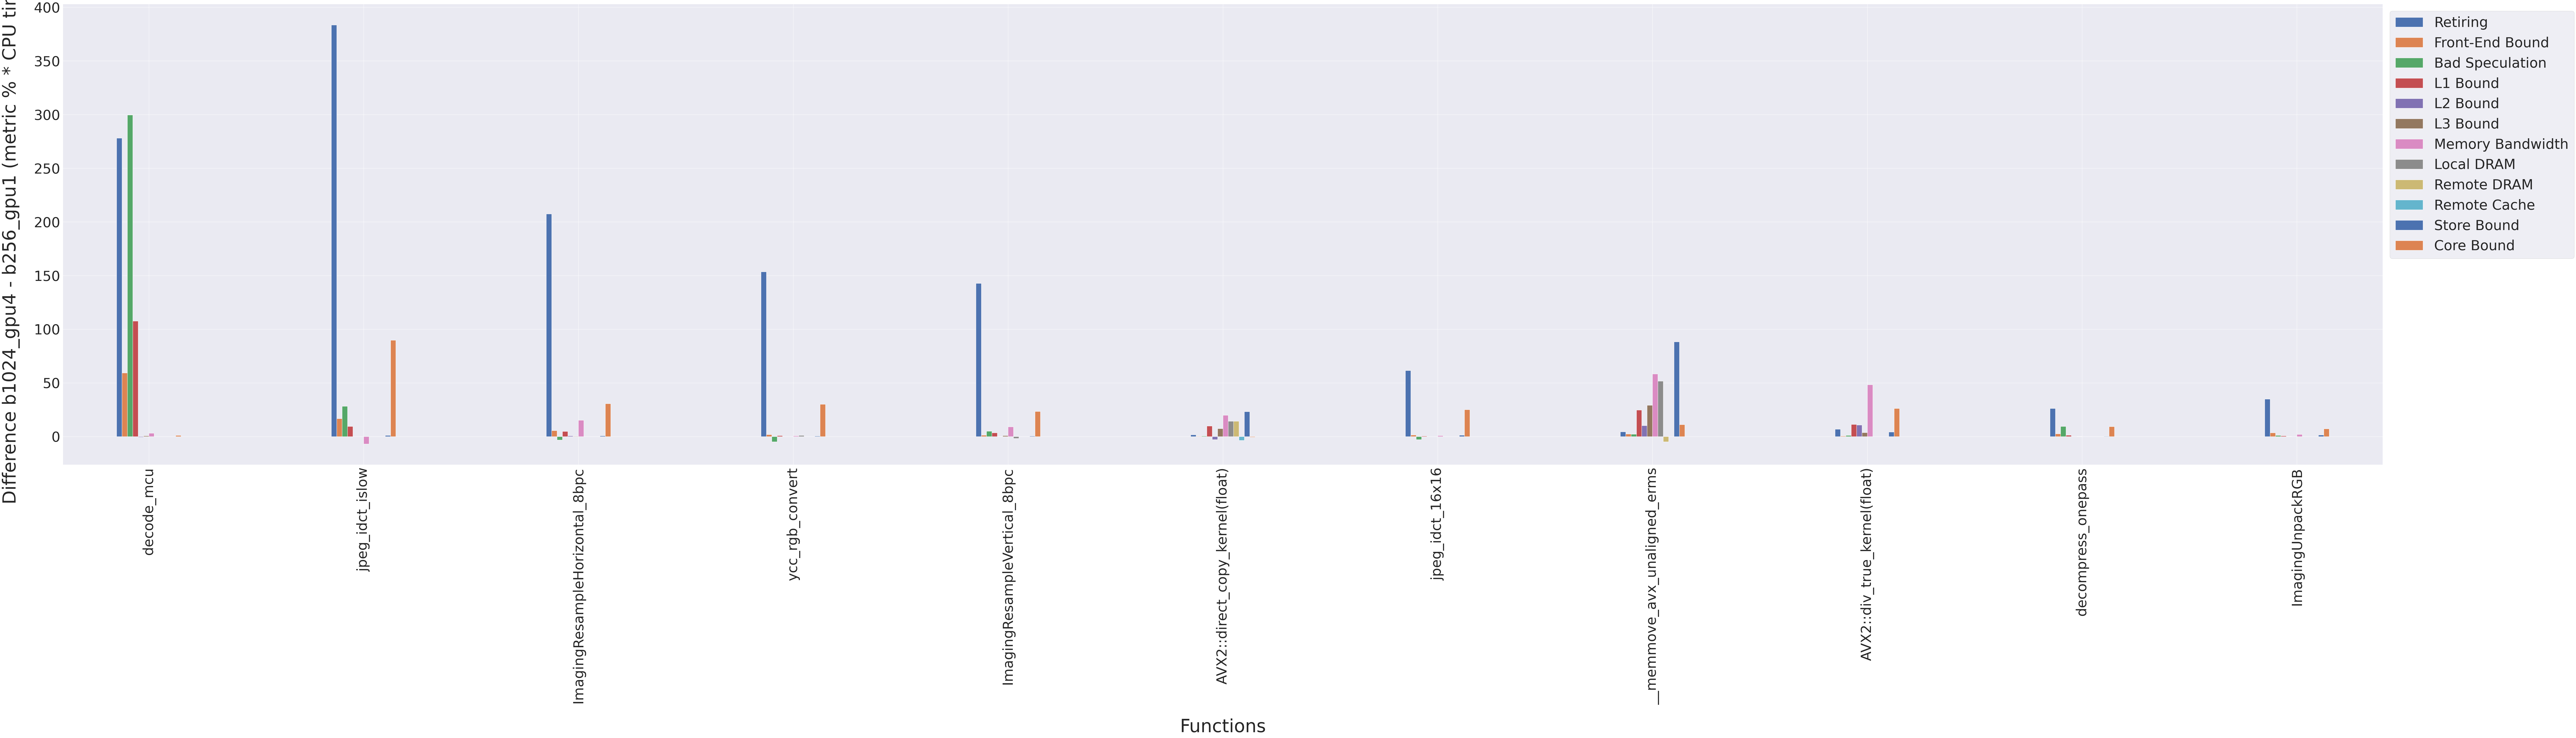

In [130]:
# plot bar graph for df3 with functions on x axis and all other columns on y axis
df3.plot(x='Functions', kind='bar', figsize=(150, 30), fontsize=50, width=0.3)

#  add x axis label
plt.xlabel('Functions')
# add y axis label
plt.ylabel(f'Difference {config2} - {config1} (metric % * CPU time) ')
# add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=50)

In [131]:
df3.head(len(df3))

,Functions,Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound
0,decode_mcu,278.126486,59.178119,299.650110,107.550199,-0.560960,0.639711,3.042180,0.000000,0.00000,0.000000,0.000000,1.092811
1,jpeg_idct_islow,383.557981,16.611512,28.158737,9.459090,0.000000,0.000000,-6.909746,0.000000,0.00000,0.000000,1.051010,89.819700
2,ImagingResampleHorizontal_8bpc,207.462509,5.573736,-3.308720,4.838853,0.658551,0.244961,15.148666,0.000000,0.00000,0.000000,0.658551,30.715915
3,ycc_rgb_convert,153.539966,1.827296,-4.798010,0.913648,0.000000,0.000000,0.751932,1.066052,0.00000,0.000000,0.533026,30.033559
4,ImagingResampleVertical_8bpc,142.761315,1.273010,5.031785,3.416970,-0.288125,0.810695,9.037075,-1.728750,0.00000,0.000000,0.462315,23.442245
5,AVX2::direct_copy_kernel(float),1.566020,0.305825,0.440290,9.842295,-2.752365,7.317185,19.915640,14.280000,14.28000,-3.499705,23.213095,-0.578310
6,jpeg_idct_16x16,61.423405,1.386445,-2.845000,0.481310,0.000000,0.000000,0.879765,0.000000,0.00000,0.000000,1.162355,24.999885
7,__memmove_avx_unaligned_erms,4.362480,2.416440,2.206170,24.740490,10.261710,29.219910,58.314060,51.642570,-4.83795,0.000000,88.304430,11.191260
8,AVX2::div_true_kernel(float),6.872165,0.508695,1.130010,11.362285,10.737080,3.641620,48.334125,0.000000,0.00000,0.000000,4.135315,26.105115
9,decompress_onepass,26.236765,2.604775,9.449530,1.205395,-0.096815,0.048230,-0.018460,0.000000,0.00000,0.000000,0.241505,9.264420


In [138]:
# only keep float with two decimal places
df3 = df3.round(2)

In [139]:
df3.head(len(df3))

,Functions,Retiring,Front-End Bound,Bad Speculation,L1 Bound,L2 Bound,L3 Bound,Memory Bandwidth,Local DRAM,Remote DRAM,Remote Cache,Store Bound,Core Bound
0,decode_mcu,278.13,59.18,299.65,107.55,-0.56,0.64,3.04,0.00,0.00,0.0,0.00,1.09
1,jpeg_idct_islow,383.56,16.61,28.16,9.46,0.00,0.00,-6.91,0.00,0.00,0.0,1.05,89.82
2,ImagingResampleHorizontal_8bpc,207.46,5.57,-3.31,4.84,0.66,0.24,15.15,0.00,0.00,0.0,0.66,30.72
3,ycc_rgb_convert,153.54,1.83,-4.80,0.91,0.00,0.00,0.75,1.07,0.00,0.0,0.53,30.03
4,ImagingResampleVertical_8bpc,142.76,1.27,5.03,3.42,-0.29,0.81,9.04,-1.73,0.00,0.0,0.46,23.44
5,AVX2::direct_copy_kernel(float),1.57,0.31,0.44,9.84,-2.75,7.32,19.92,14.28,14.28,-3.5,23.21,-0.58
6,jpeg_idct_16x16,61.42,1.39,-2.84,0.48,0.00,0.00,0.88,0.00,0.00,0.0,1.16,25.00
7,__memmove_avx_unaligned_erms,4.36,2.42,2.21,24.74,10.26,29.22,58.31,51.64,-4.84,0.0,88.30,11.19
8,AVX2::div_true_kernel(float),6.87,0.51,1.13,11.36,10.74,3.64,48.33,0.00,0.00,0.0,4.14,26.11
9,decompress_onepass,26.24,2.60,9.45,1.21,-0.10,0.05,-0.02,0.00,0.00,0.0,0.24,9.26


In [132]:
# create a dataframe for rpevious cell
df4 = pd.DataFrame(columns=['Functions', 'Metric', 'Value'])
for i, row in df3.iterrows():
    for j, col in enumerate(df3.columns):
        if j == 0:
            continue
        if row[col] > 10:
            temp_df = pd.DataFrame({'Functions': row['Functions'], 'Metric': col, 'Value': row[col]}, index=[0])
            df4 = pd.concat([df4,temp_df], ignore_index=True)
print(df4.head(len(df4)))

                          Functions            Metric       Value
0                        decode_mcu          Retiring  278.126486
1                        decode_mcu   Front-End Bound   59.178119
2                        decode_mcu   Bad Speculation  299.650110
3                        decode_mcu          L1 Bound  107.550199
4                   jpeg_idct_islow          Retiring  383.557981
5                   jpeg_idct_islow   Front-End Bound   16.611512
6                   jpeg_idct_islow   Bad Speculation   28.158737
7                   jpeg_idct_islow        Core Bound   89.819700
8    ImagingResampleHorizontal_8bpc          Retiring  207.462509
9    ImagingResampleHorizontal_8bpc  Memory Bandwidth   15.148666
10   ImagingResampleHorizontal_8bpc        Core Bound   30.715915
11                  ycc_rgb_convert          Retiring  153.539966
12                  ycc_rgb_convert        Core Bound   30.033559
13     ImagingResampleVertical_8bpc          Retiring  142.761315
14     Ima

/tmp/ipykernel_142369/71256342.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df4 = pd.concat([df4,temp_df], ignore_index=True)


In [144]:
# create a dataframe for rpevious cell
total = 0
df4 = pd.DataFrame(columns=['Functions', 'Metric', 'Value'])
for i, row in df3.iterrows():
    for j, col in enumerate(df3.columns):
        if j == 0:
            continue
        if row[col] > 0:
            total += row[col]
            temp_df = pd.DataFrame({'Functions': row['Functions'], 'Metric': col, 'Value': row[col]}, index=[0])
            df4 = pd.concat([df4,temp_df], ignore_index=True)
print(total)
# sort df4 by 'Value' column
df4 = df4.sort_values(by=['Value'], ascending=False).reset_index(drop=True)
# print(df4.head(len(df4)))

# loop through df4 and print each row
for i, row in df4.iterrows():
    print(f"{row['Functions']}\n\t{row['Metric']}\n\t\t{row['Value']}")

2595.259999999999
jpeg_idct_islow
	Retiring
		383.56
decode_mcu
	Bad Speculation
		299.65
decode_mcu
	Retiring
		278.13
ImagingResampleHorizontal_8bpc
	Retiring
		207.46
ycc_rgb_convert
	Retiring
		153.54
ImagingResampleVertical_8bpc
	Retiring
		142.76
decode_mcu
	L1 Bound
		107.55
jpeg_idct_islow
	Core Bound
		89.82
__memmove_avx_unaligned_erms
	Store Bound
		88.3
jpeg_idct_16x16
	Retiring
		61.42
decode_mcu
	Front-End Bound
		59.18
__memmove_avx_unaligned_erms
	Memory Bandwidth
		58.31
__memmove_avx_unaligned_erms
	Local DRAM
		51.64
AVX2::div_true_kernel(float)
	Memory Bandwidth
		48.33
ImagingUnpackRGB
	Retiring
		34.88
ImagingResampleHorizontal_8bpc
	Core Bound
		30.72
ycc_rgb_convert
	Core Bound
		30.03
__memmove_avx_unaligned_erms
	L3 Bound
		29.22
jpeg_idct_islow
	Bad Speculation
		28.16
decompress_onepass
	Retiring
		26.24
AVX2::div_true_kernel(float)
	Core Bound
		26.11
jpeg_idct_16x16
	Core Bound
		25.0
__memmove_avx_unaligned_erms
	L1 Bound
		24.74
ImagingResampleVertical_8

/tmp/ipykernel_142369/3090198866.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df4 = pd.concat([df4,temp_df], ignore_index=True)


In [141]:
# create a dataframe for rpevious cell
total = 0
df4 = pd.DataFrame(columns=['Functions', 'Metric', 'Value'])
for i, row in df3.iterrows():
    for j, col in enumerate(df3.columns):
        if j == 0:
            continue
        total += row[col]

print(f"Total difference between {config2} and {config1} is {total:.2f}")

Total difference between b1024_gpu4 and b256_gpu1 is 2563.03


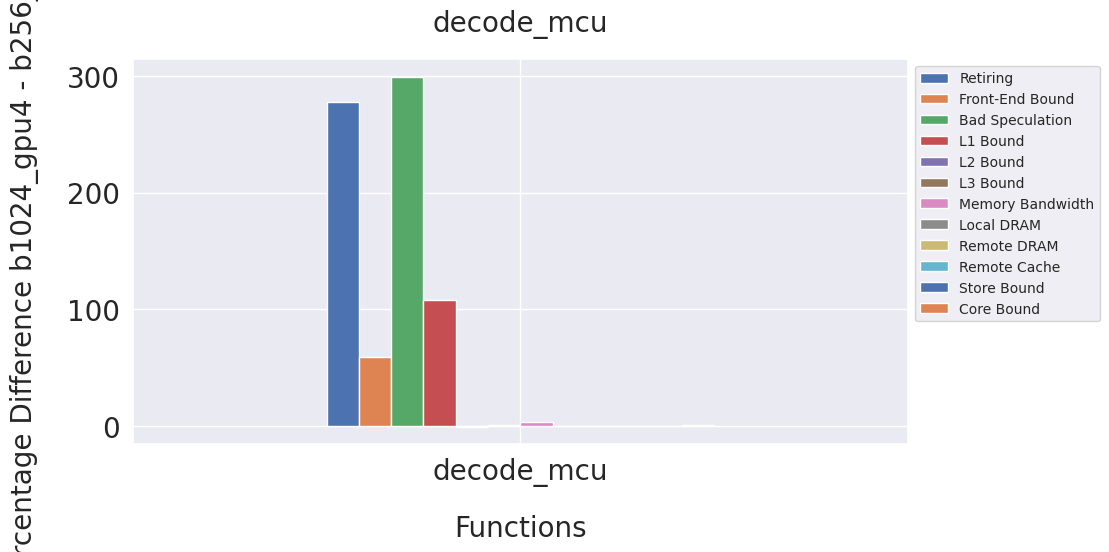

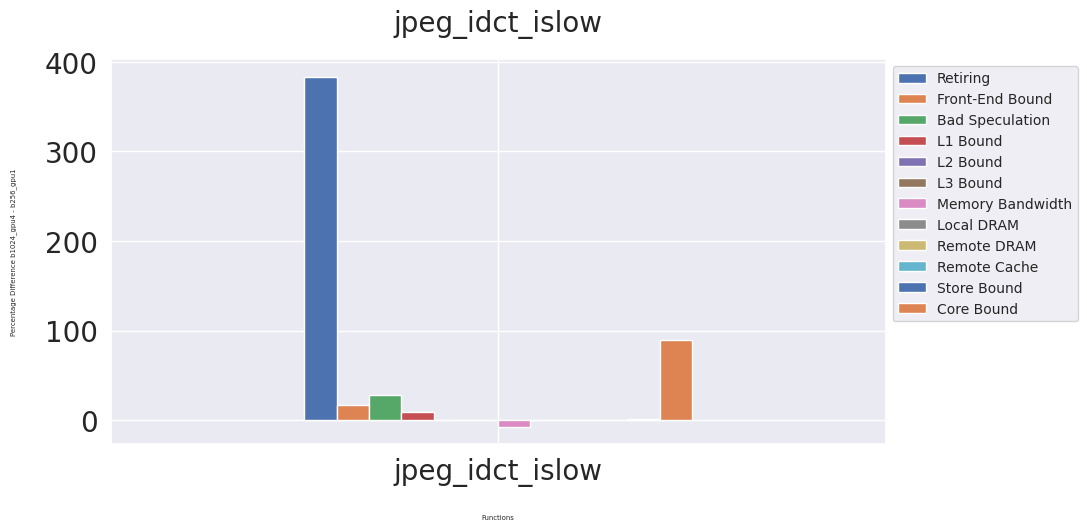

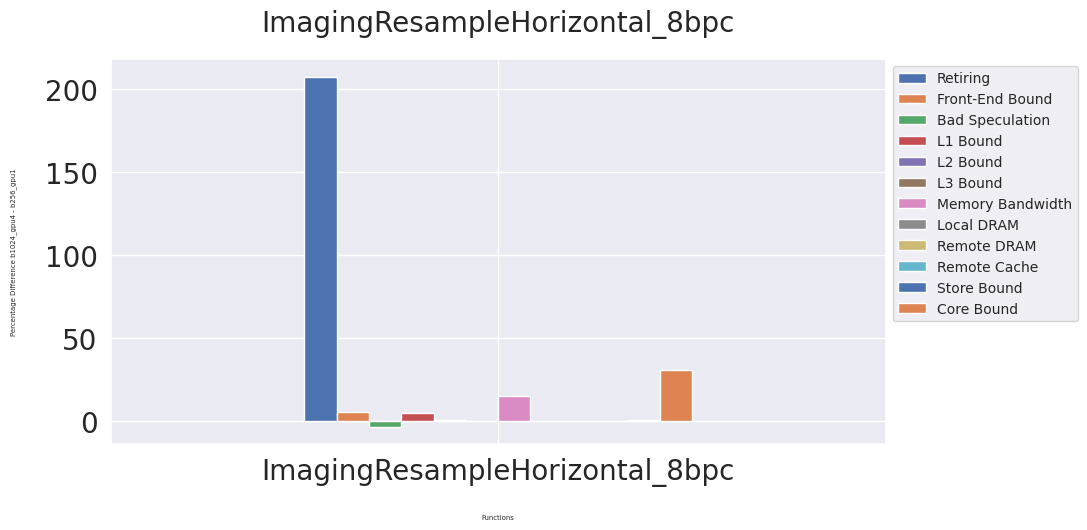

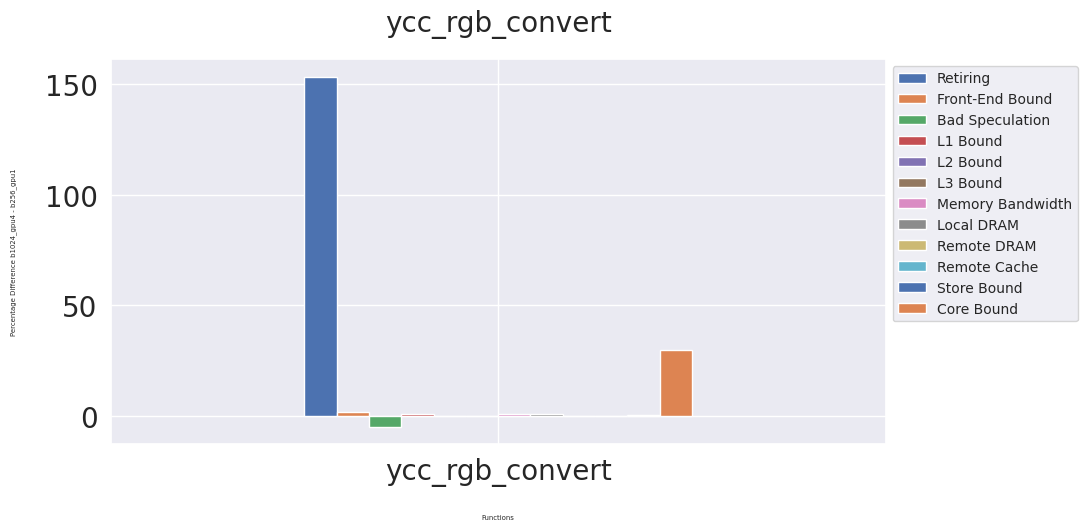

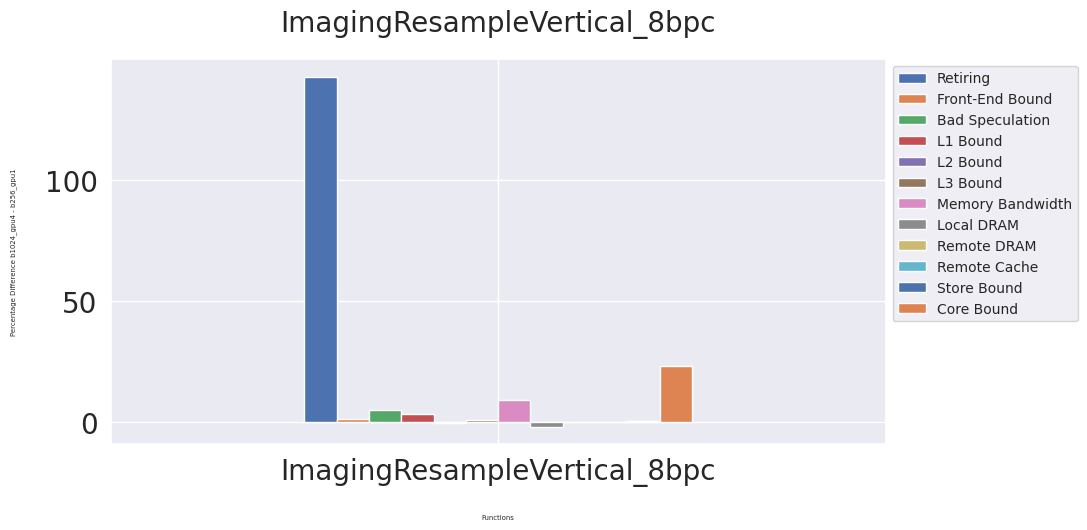

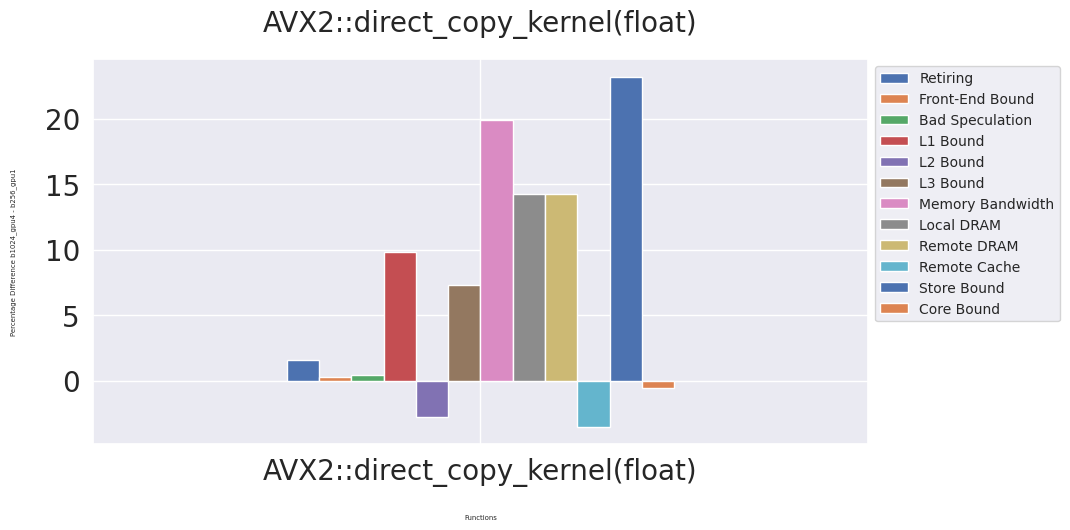

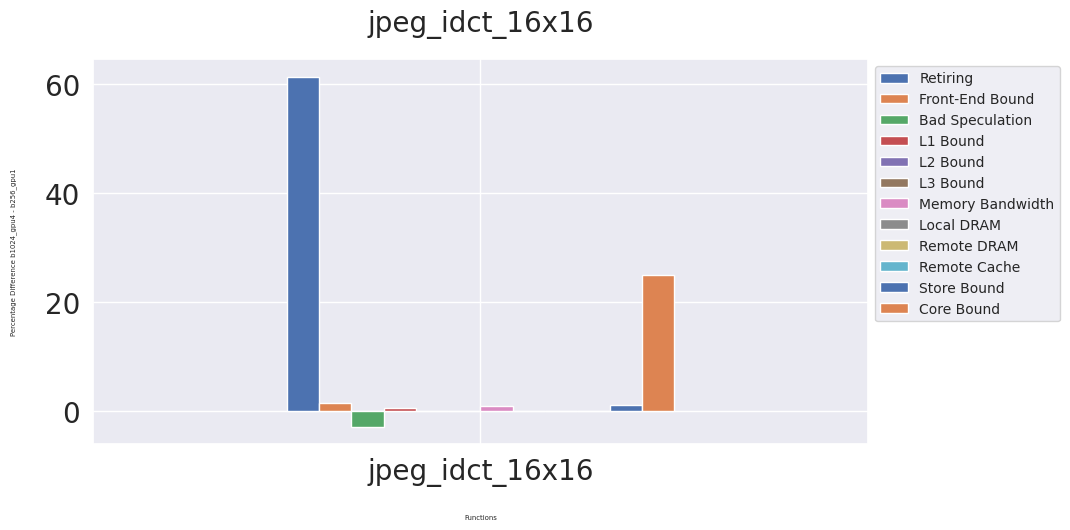

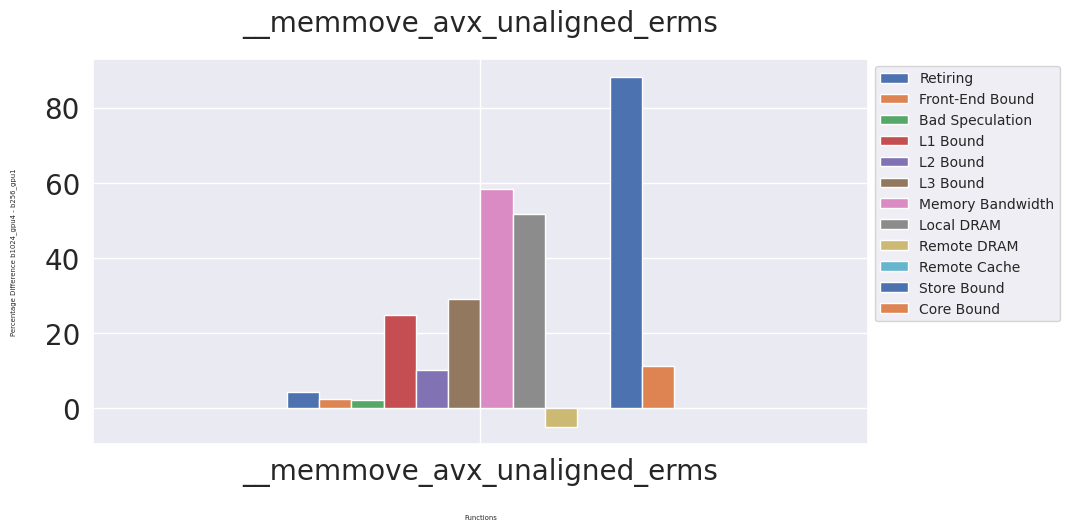

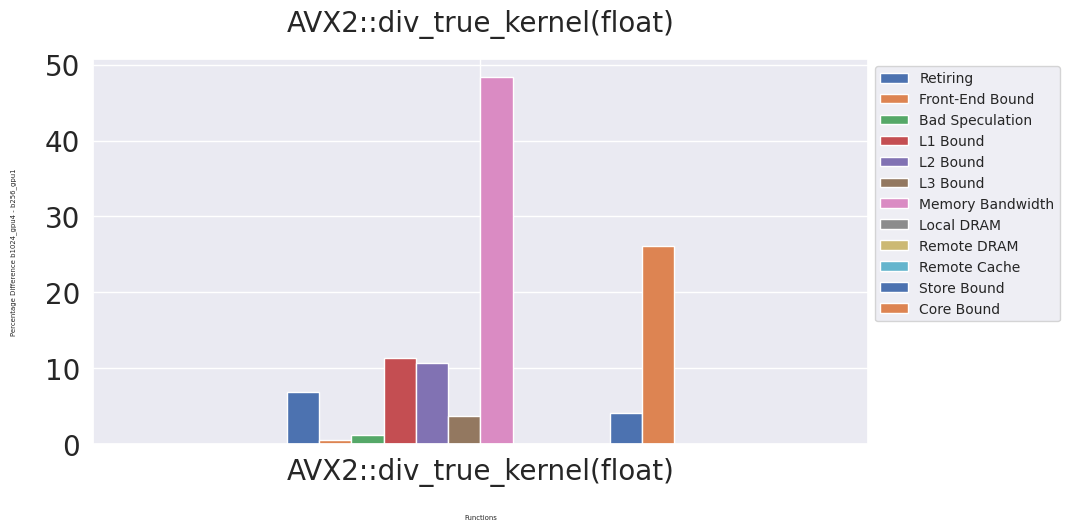

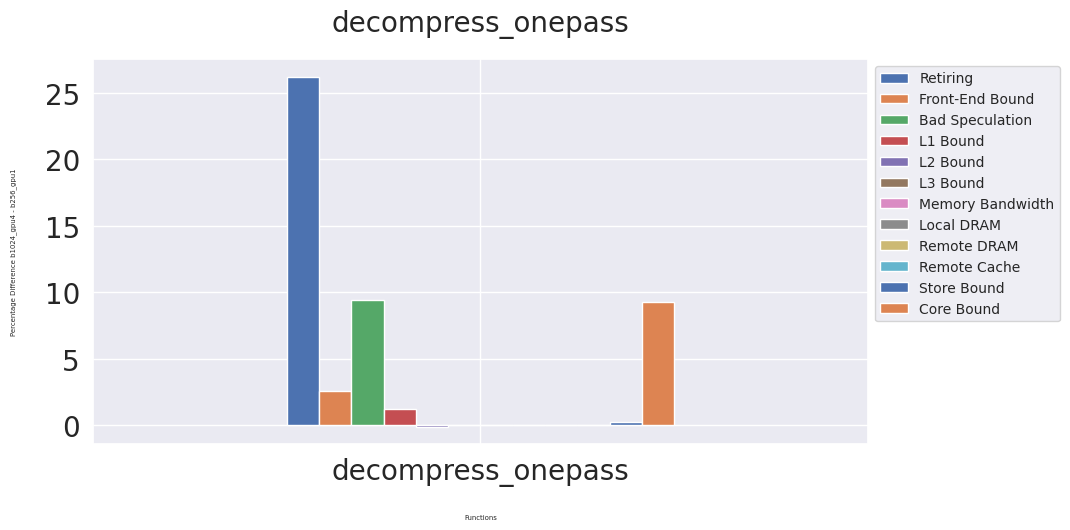

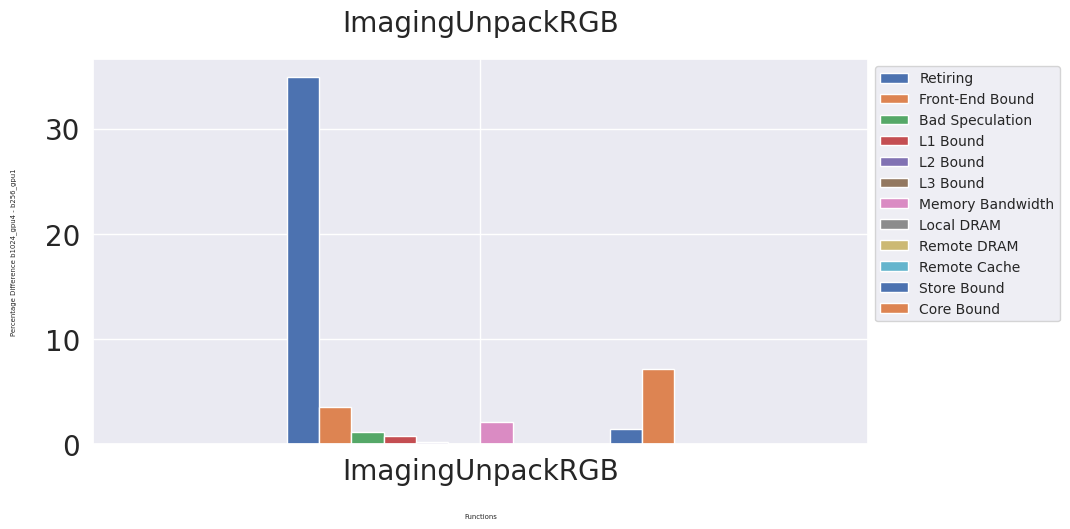

In [134]:
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
# # increase size of axis label size
plt.rcParams['axes.labelsize'] = 20
# increase title size
plt.rcParams['axes.titlesize'] = 20
# increase space between axis label and axis
plt.rcParams['axes.labelpad'] = 20
# increase space between title and plot
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['font.size'] = 20
# plot for each function on a subplot
for func in df3['Functions'].unique():
    df3[df3['Functions'] == func].plot(x='Functions', kind='bar', figsize=(10, 5))
    plt.xlabel('Functions')
    plt.ylabel(f'Percentage Difference {config2} - {config1}')
    # make x axis label horizontal
    plt.xticks(rotation=0)
    plt.title(func)
    # make x axis title font size smaller
    plt.rcParams['axes.labelsize'] = 5
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.show()